# Calc date Model exploration in PyTorch

## Import all required modules

In [1]:
import os
from ficc.utils.auxiliary_variables import PREDICTORS, IDENTIFIERS, CATEGORICAL_FEATURES, NON_CAT_FEATURES, BINARY
from ficc.data.process_data import process_data
from ficc.data.queries import *
from ficc.models import get_model_instance
from ficc.models.lstm_ysm_pytorch import ExtractLatentWrapper, ExtractTradeHistoryLatentWrapper
import gcsfs

import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn import preprocessing

import pickle

import catboost
from catboost.utils import get_gpu_device_count

import torch
from torch.utils.data import TensorDataset
import pytorch_lightning as pl

torch.multiprocessing.set_sharing_strategy('file_system')

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Seed the random-number generators

In [2]:
# Setting the random seed, for consistency
SEED = 10

pl.utilities.seed.seed_everything(SEED)

Global seed set to 10


10

## Set up the BigQuery client

In [3]:
# Setting up the credentials for GCP
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "eng-reactor-287421-112eb767e1b3.json"

# Initializing the big query client
bq_client = bigquery.Client()

## Set up hyper-parameters

In [4]:
TRAIN_TEST_SPLIT = 0.85

SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

## Data Preparation

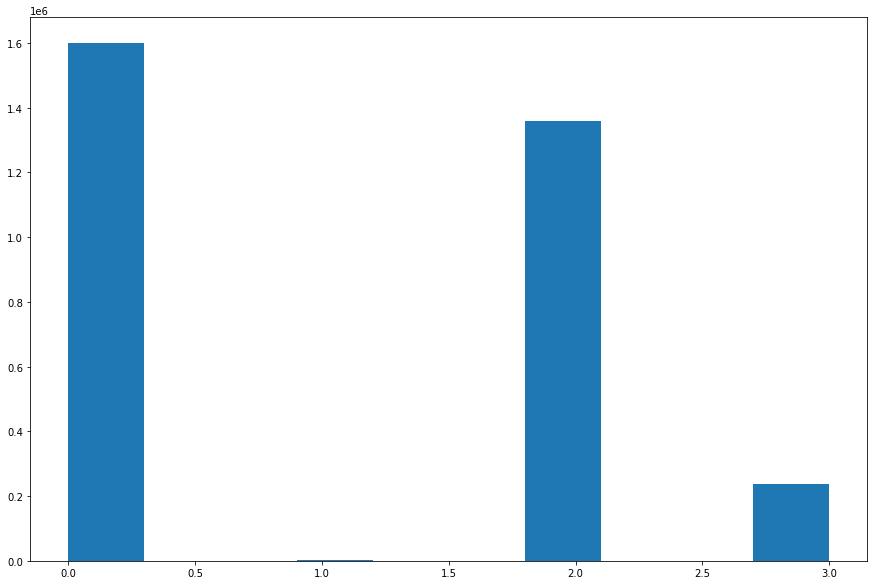

In [5]:
with open('processed_data.pkl', 'rb') as f:
    df = pd.read_pickle(f)

df = df[~df.purpose_sub_class.isin([6, 20, 21, 22, 44, 57, 90, 106])]
df = df[~df.called_redemption_type.isin([18, 19])]

# Add additional features
processed_data = df[IDENTIFIERS + PREDICTORS + ['trade_datetime']]

# A few features such as the initial issue amount cannot be filled with their logical counterparts as their values are not known and hence are dropped.
processed_data = processed_data.dropna()
unprocessed_data = processed_data.copy()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))
_ = ax.hist(processed_data.calc_day_cat)

## Prepare the datasets

In [6]:
# Splitting the date into train and test set
test_dataframe = processed_data[processed_data.trade_datetime >= '2022-05-21']
train_dataframe = processed_data[processed_data.trade_datetime < '2022-05-21']
unprocessed_test_df = unprocessed_data[unprocessed_data.trade_datetime >= '2022-05-21']

# Split the training data in to train and validation set
val_dataframe = train_dataframe[train_dataframe.trade_datetime >= '2022-05-07']
train_dataframe = train_dataframe[train_dataframe.trade_datetime < '2022-05-07']

def prep_input(df):
    x = df[NON_CAT_FEATURES + BINARY + CATEGORICAL_FEATURES].copy()
    for col in BINARY:
        if x[col].dtype == 'category':
            x[col] = x[col].astype('bool')
    x.purpose_class = x.purpose_class.astype('int32')
    return x

def prep_cd_label(df):
    return df.calc_day_cat.astype('int32').copy()

def prep_ys_label(df):
    return df.yield_spread.astype('float32').copy()

x_train = prep_input(train_dataframe)
y_cd_train = prep_cd_label(train_dataframe)
y_ys_train = prep_ys_label(train_dataframe)

x_val = prep_input(val_dataframe)
y_cd_val = prep_cd_label(val_dataframe)
y_ys_val = prep_ys_label(val_dataframe)

x_test = prep_input(test_dataframe)
y_cd_test = prep_cd_label(test_dataframe)
y_ys_test = prep_ys_label(test_dataframe)

train_cd_pool = catboost.Pool(x_train, y_cd_train, cat_features=CATEGORICAL_FEATURES, feature_names=NON_CAT_FEATURES + BINARY + CATEGORICAL_FEATURES)
val_cd_pool = catboost.Pool(x_val, y_cd_val, cat_features=CATEGORICAL_FEATURES)
test_cd_pool = catboost.Pool(x_test, y_cd_test, cat_features=CATEGORICAL_FEATURES)

train_ys_pool = catboost.Pool(x_train, y_ys_train, cat_features=CATEGORICAL_FEATURES, feature_names=NON_CAT_FEATURES + BINARY + CATEGORICAL_FEATURES)
val_ys_pool = catboost.Pool(x_val, y_ys_val, cat_features=CATEGORICAL_FEATURES)
test_ys_pool = catboost.Pool(x_test, y_ys_test, cat_features=CATEGORICAL_FEATURES)


In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Uniform normalization
normalizers = []
for f in NON_CAT_FEATURES + BINARY:
    normalizers.append(preprocessing.StandardScaler())
    processed_data.loc[:, f] = normalizers[-1].fit_transform(processed_data[f].to_numpy().astype('float32').reshape(-1, 1))

# Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(
        processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep

def create_input(df):
    sdf = df[IDENTIFIERS + PREDICTORS]

    global encoders
    datalist = []
    datalist.append(torch.tensor(np.stack(sdf['trade_history'])).float())

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(
            sdf[f].to_numpy().astype('float32'), axis=1))
    datalist.append(torch.tensor(np.concatenate(noncat_and_binary, axis=-1)))

    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(sdf[f])
        datalist.append(torch.tensor(encoded).long())

    return datalist

def create_label(df):
    sdf = df[IDENTIFIERS + PREDICTORS]
    return torch.tensor(sdf.yield_spread.to_numpy()).float()

# Splitting the date into train and test set
test_dataframe = processed_data[processed_data.trade_datetime >= '2022-05-21']
train_dataframe = processed_data[processed_data.trade_datetime < '2022-05-21']

# Split the training data in to train and validation set
val_dataframe = train_dataframe[train_dataframe.trade_datetime >= '2022-05-07']
train_dataframe = train_dataframe[train_dataframe.trade_datetime < '2022-05-07']

train_ds = TensorDataset(*create_input(train_dataframe), create_label(train_dataframe))
train_loader = DataLoader(train_ds, batch_size=10000, num_workers=os.cpu_count())

val_ds = TensorDataset(*create_input(val_dataframe), create_label(val_dataframe))
val_loader = DataLoader(val_ds, batch_size=10000, num_workers=os.cpu_count())

x_test_pyt = create_input(test_dataframe)
y_cd_test_pyt = create_label(test_dataframe)
test_ds = TensorDataset(*x_test_pyt, y_cd_test_pyt)
test_loader = DataLoader(test_ds, batch_size=10000, num_workers=os.cpu_count())

## Train a calc-date model

This is a simply classification task as the model outputs an integer index that specifies which date to use for the calc date. NOTE: the green dot on the graph indicates the lowest loss on the validation dataset.

In [8]:
model = catboost.CatBoostClassifier(
    random_seed=SEED,
    depth=12,           # Max depth of a tree
    iterations=1000,    # Max number of trees in the forest
    task_type="GPU" if get_gpu_device_count() > 0 else "CPU",   # Use GPU if available
)
model.fit(train_cd_pool, eval_set=val_cd_pool, plot=True, silent=True)

print(f"Test accuracy is {model.score(test_cd_pool)}")

model.save_model('calc_date_model.cbm')

# model.plot_tree(0, pool=test_cd_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test accuracy is 0.9670866004763562


In [9]:
model = catboost.CatBoostClassifier(
    task_type="GPU" if get_gpu_device_count() > 0 else "CPU",   # Use GPU if available
)
model.load_model('calc_date_model.cbm')
prediction = model.predict(x_test)
successes = prediction.squeeze() == y_cd_test
success_dataframe = unprocessed_test_df[successes]
failures = prediction.squeeze() != y_cd_test
failure_dataframe = unprocessed_test_df[failures]

print(f"Test accuracy is {np.count_nonzero(successes.to_numpy()) / len(successes)}")

Test accuracy is 0.9670866004763562


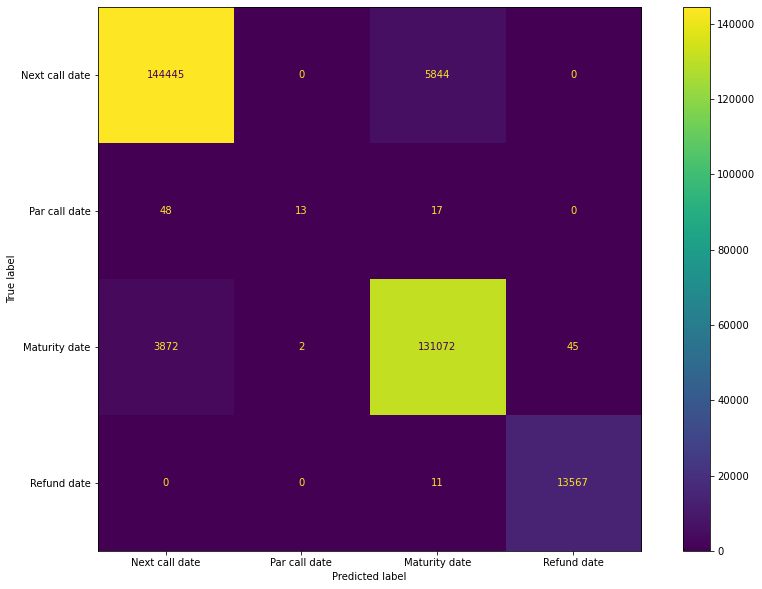

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 10))
ConfusionMatrixDisplay.from_predictions(
    y_cd_test, 
    prediction, 
    display_labels=['Next call date', 'Par call date', 'Maturity date', 'Refund date'],
    ax=ax)
plt.show()

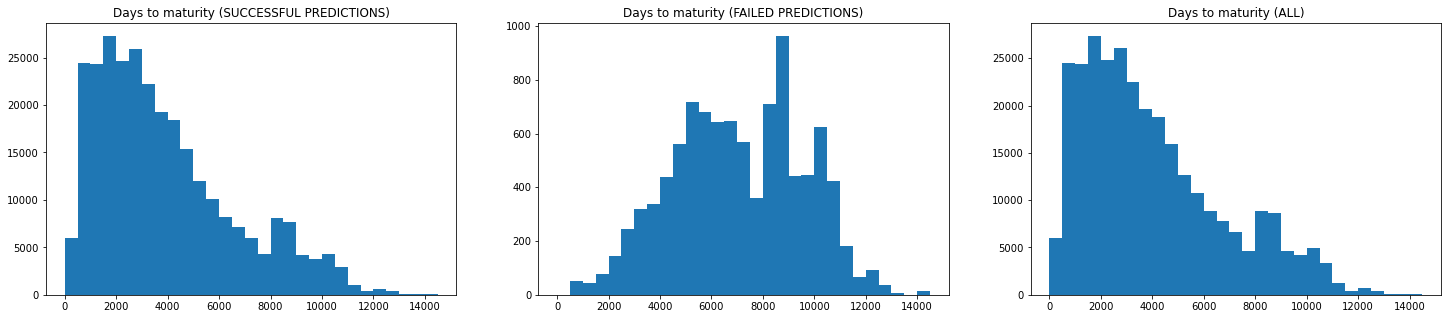

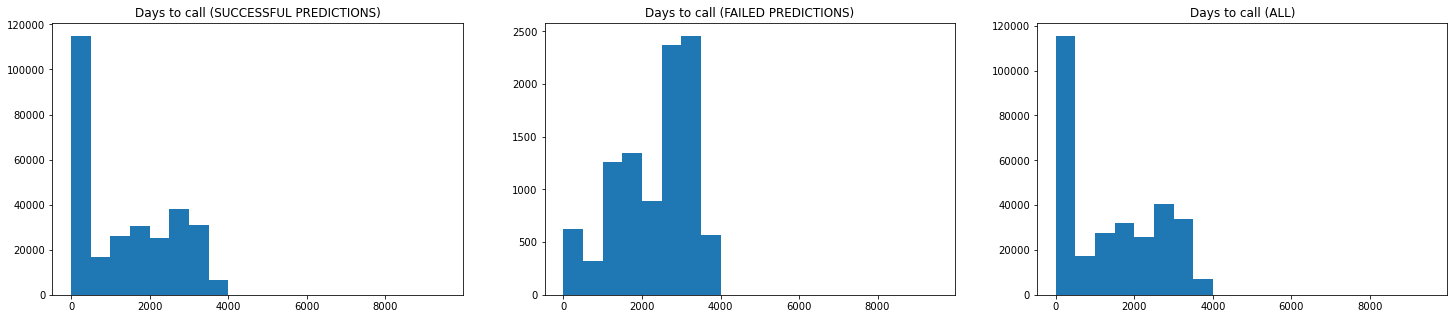

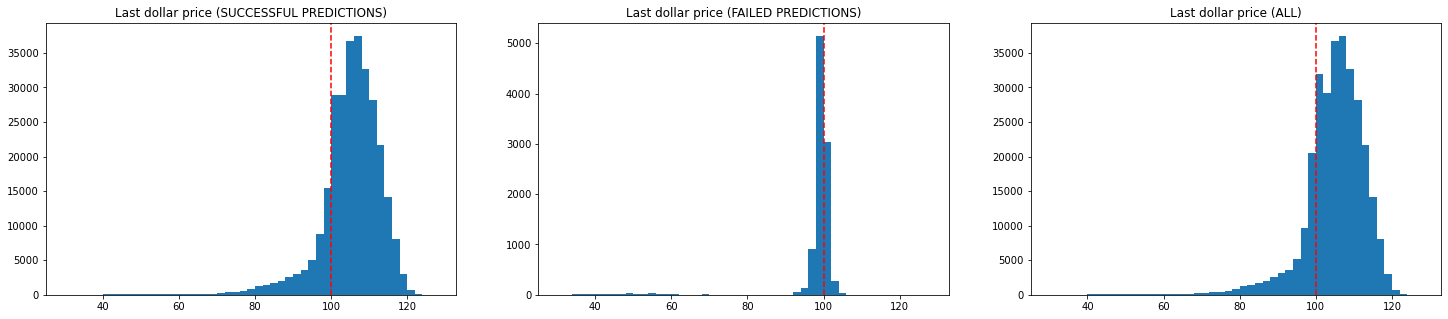

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[0].set_title('Days to maturity (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[1].set_title('Days to maturity (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_df.days_to_maturity, bins=range(0, 15000, 500))
ax[2].set_title('Days to maturity (ALL)')
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[0].set_title('Days to call (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[1].set_title('Days to call (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_df.days_to_call, bins=range(0, 10000, 500))
ax[2].set_title('Days to call (ALL)')
plt.show()
# Days to Settle/Refund didn't show differences, so they were removed
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(success_dataframe.last_dollar_price, bins=range(30, 130, 2))
ax[0].set_title('Last dollar price (SUCCESSFUL PREDICTIONS)')
ax[0].axvline(100.0, color='r', linestyle='--')
ax[1].hist(failure_dataframe.last_dollar_price, bins=range(30, 130, 2))
ax[1].set_title('Last dollar price (FAILED PREDICTIONS)')
ax[1].axvline(100.0, color='r', linestyle='--')
ax[2].hist(unprocessed_test_df.last_dollar_price, bins=range(30, 130, 2))
ax[2].set_title('Last dollar price (ALL)')
ax[2].axvline(100.0, color='r', linestyle='--')
plt.show()

In [12]:
model_params = {
    'num_trade_history_features': NUM_FEATURES,
    'non_categorical_size': NON_CAT_FEATURES + BINARY,
    'category_sizes': fmax,
    'lstm_sizes': [50, 100],
    'embed_sizes': 15,
    'tabular_sizes': [400, 200, 100],
    'tabular_resblocks': 1,
    'final_sizes': [300, 100],
    'final_resblocks': 0,
    'dropout': 0.3758110031582248,
    'learning_schedule': 'constant', 
    'learning_rate': 0.002, 
    'weight_decay': 0.0004
}

model = get_model_instance(
    "lstm_calc_date_model_pytorch",
    **model_params)

print(f'Reloading best model')
model = model.load_from_checkpoint(
    checkpoint_path='best_cd_model.ckpt',
    **model_params
)

model.eval()

logits = torch.softmax(model.cuda()(*[x.cuda() for x in create_input(test_dataframe)]), dim=-1)
prediction = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
logits = logits.detach().squeeze().cpu().numpy() # Convert to cpu now, so the above calc can occur on gpu
successes = prediction == y_cd_test
success_dataframe = unprocessed_test_df[successes]
failures = prediction != y_cd_test
failure_dataframe = unprocessed_test_df[failures]

print(f"Test accuracy is {np.count_nonzero(successes) / successes.shape[0]}")

Reloading best model
Test accuracy is 0.9701842534856959


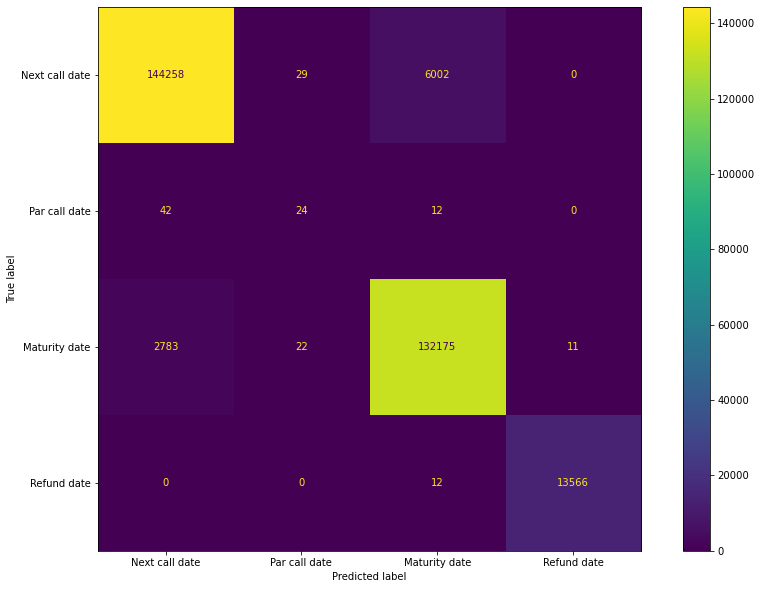

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 10))
ConfusionMatrixDisplay.from_predictions(
    y_cd_test, 
    prediction, 
    display_labels=['Next call date', 'Par call date', 'Maturity date', 'Refund date'],
    ax=ax)
plt.show()

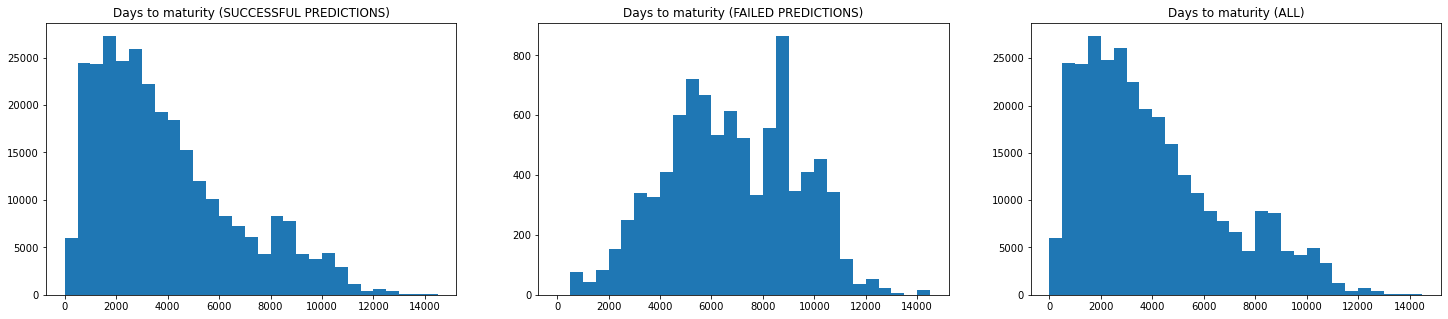

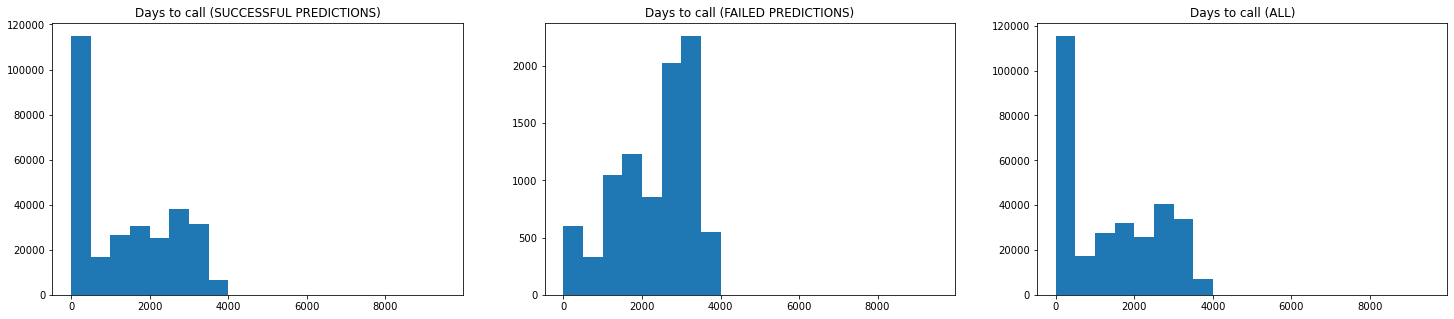

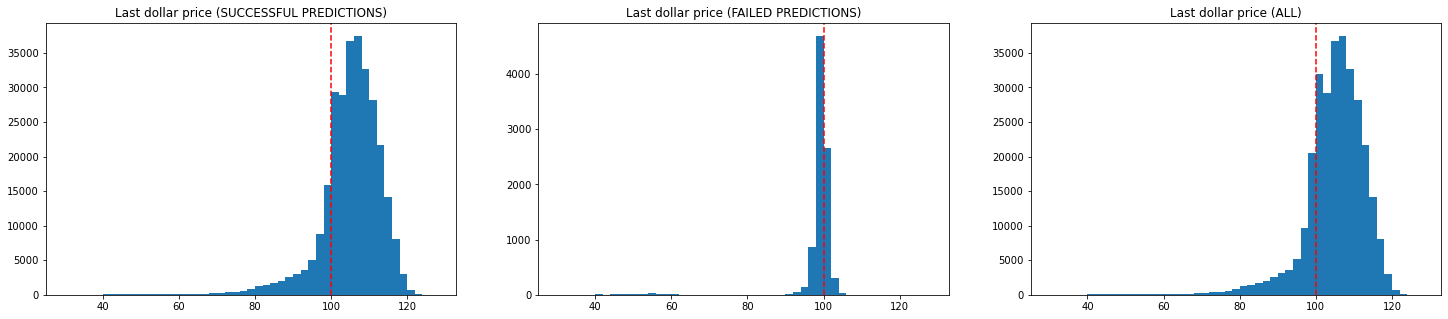

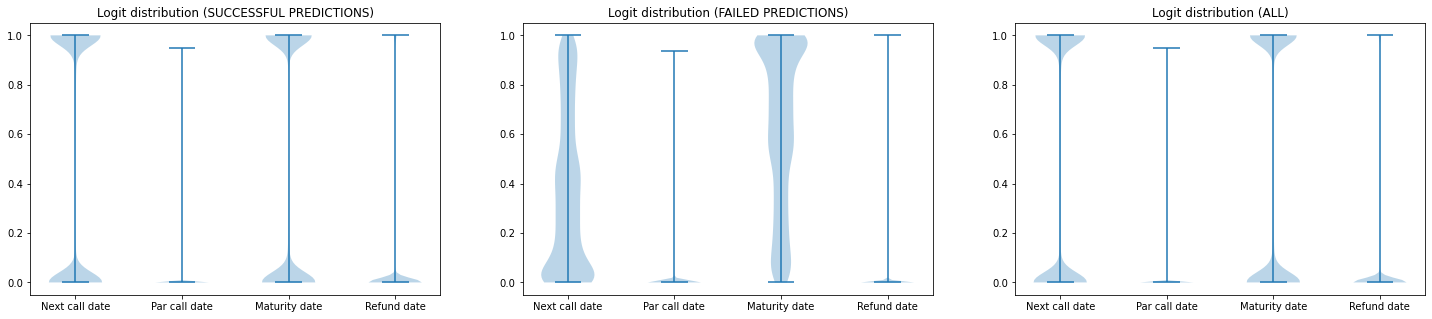

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[0].set_title('Days to maturity (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[1].set_title('Days to maturity (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_df.days_to_maturity, bins=range(0, 15000, 500))
ax[2].set_title('Days to maturity (ALL)')
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[0].set_title('Days to call (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[1].set_title('Days to call (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_df.days_to_call, bins=range(0, 10000, 500))
ax[2].set_title('Days to call (ALL)')
plt.show()
# Days to Settle/Refund didn't show differences, so they were removed
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(success_dataframe.last_dollar_price, bins=range(30, 130, 2))
ax[0].set_title('Last dollar price (SUCCESSFUL PREDICTIONS)')
ax[0].axvline(100.0, color='r', linestyle='--')
ax[1].hist(failure_dataframe.last_dollar_price, bins=range(30, 130, 2))
ax[1].set_title('Last dollar price (FAILED PREDICTIONS)')
ax[1].axvline(100.0, color='r', linestyle='--')
ax[2].hist(unprocessed_test_df.last_dollar_price, bins=range(30, 130, 2))
ax[2].set_title('Last dollar price (ALL)')
ax[2].axvline(100.0, color='r', linestyle='--')
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].violinplot(dataset=logits[successes],positions=range(4))
ax[0].set_title('Logit distribution (SUCCESSFUL PREDICTIONS)')
ax[0].set_xticks(range(4))
ax[0].set_xticklabels(['Next call date', 'Par call date', 'Maturity date', 'Refund date'])
ax[1].violinplot(dataset=logits[failures],positions=range(4))
ax[1].set_title('Logit distribution (FAILED PREDICTIONS)')
ax[1].set_xticks(range(4))
ax[1].set_xticklabels(['Next call date', 'Par call date', 'Maturity date', 'Refund date'])
ax[2].violinplot(dataset=logits,positions=range(4))
ax[2].set_title('Logit distribution (ALL)')
ax[2].set_xticks(range(4))
ax[2].set_xticklabels(['Next call date', 'Par call date', 'Maturity date', 'Refund date'])
plt.show()


## Train a yield-spread model (#1)

This model is a simple catboost regression task using the same features as the calc-date model above.

In [15]:
model = catboost.CatBoostRegressor(
    random_seed=SEED,
    depth=12,           # Max depth of a tree
    iterations=1000,    # Max number of trees in the forest
    task_type="GPU" if get_gpu_device_count() > 0 else "CPU",   # Use GPU if available
)
model.fit(train_ys_pool, eval_set=val_ys_pool, plot=True, silent=True)
prediction = model.predict(test_ys_pool)
print(f"Test MAE is {np.mean(np.abs(y_ys_test - prediction))}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test MAE is 18.85126447266854


## Generate latent feature representations of each trade using a trained DL model

The theory here is that the deep-learning model learns an internal representation of the cusip where each element of the latent vector, while not necessarily easily interpretable, is in a space where it more directly informs the estimate of the model (be it yield-spread or calc-date). I set aside the output of the trade-history submodule as the trade-history-specific latent vector, and the output of the second last layer of the full model as the latent vector for the whole trade.

In [16]:
model_params = {
    'num_trade_history_features': NUM_FEATURES,
    'non_categorical_size': NON_CAT_FEATURES + BINARY,
    'category_sizes': fmax,
    'lstm_sizes': [50, 100],
    'embed_sizes': 15,
    'tabular_sizes': [400, 200, 100],
    'tabular_resblocks': 1,
    'final_sizes': [300, 100],
    'final_resblocks': 0,
    'dropout': 0.3758110031582248,
    'learning_schedule': 'constant', 
    'learning_rate': 0.00017360566254027907, 
    'weight_decay': 0.00039784787398219684
}

model = get_model_instance(
    "lstm_yield_spread_model_pytorch",
    **model_params)

# Reload the checkpoint of the best model, to this point
model = model.load_from_checkpoint(
    checkpoint_path="best_ys_model.ckpt",
    **model_params
)
model.eval()

with torch.no_grad():
    latent_model = ExtractLatentWrapper(model)
    x_train_latent = pd.DataFrame(latent_model(*create_input(train_dataframe)).numpy())
    x_val_latent = pd.DataFrame(latent_model(*create_input(val_dataframe)).numpy())
    x_test_latent = pd.DataFrame(latent_model(*create_input(test_dataframe)).numpy())

    latent_model = ExtractTradeHistoryLatentWrapper(model)
    x_train_trade_history_latent = pd.DataFrame(latent_model(*create_input(train_dataframe)).numpy())
    x_val_trade_history_latent = pd.DataFrame(latent_model(*create_input(val_dataframe)).numpy())
    x_test_trade_history_latent = pd.DataFrame(latent_model(*create_input(test_dataframe)).numpy())
    
x_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

x_train_combo = pd.concat([x_train, x_train_latent], axis=1)
x_val_combo = pd.concat([x_val, x_val_latent], axis=1)
x_test_combo = pd.concat([x_test, x_test_latent], axis=1)    

x_train_trade_history_combo = pd.concat([x_train, x_train_trade_history_latent], axis=1)
x_val_trade_history_combo = pd.concat([x_val, x_val_trade_history_latent], axis=1)
x_test_trade_history_combo = pd.concat([x_test, x_test_trade_history_latent], axis=1)


## Evaluate the Deep Learning model as it is, so we have a point of comparison for the test MAE

In [17]:
from torch.utils.data import TensorDataset, DataLoader

test_ds = TensorDataset(*create_input(test_dataframe), create_label(test_dataframe))
test_loader = DataLoader(test_ds, batch_size=5000, num_workers=os.cpu_count())

evaluator = pl.Trainer(gpus=1)

print(f"Test MAE for the pure DL model is {evaluator.test(model, test_loader, verbose=False)[0]['test_mae']}")

/home/anis/anaconda3/envs/ficc/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Test MAE for the pure DL model is 16.28211212158203


## Train a hybrid yield-spread model (#2)

This hybrid model uses a trained DL model to output a latent vector for each trade, then trains a catboost model on those latent vectors.

In [18]:
model = catboost.CatBoostRegressor(
    random_seed=SEED,
    depth=12,           # Max depth of a tree
    iterations=1000,    # Max number of trees in the forest
    task_type="GPU" if get_gpu_device_count() > 0 else "CPU",   # Use GPU if available
)
model.fit(X=x_train_latent, y=y_ys_train, eval_set=(x_val_latent, y_ys_val), plot=True, silent=True)
prediction = model.predict(x_test_latent)
print(f"Test MAE is {np.mean(np.abs(y_ys_test - prediction))}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test MAE is 16.057272833164152


## Train a hybrid yield-spread model (#3)

This hybrid model uses a trained DL model to output a latent vector for each trade, then trains a catboost model on those latent vectors along with the raw input features used in the calc-date model above.

In [19]:
model = catboost.CatBoostRegressor(
    random_seed=SEED,
    depth=12,           # Max depth of a tree
    iterations=1000,    # Max number of trees in the forest
    task_type="GPU" if get_gpu_device_count() > 0 else "CPU",   # Use GPU if available
)
model.fit(X=x_train_combo, y=y_ys_train, eval_set=(x_val_combo, y_ys_val), cat_features=CATEGORICAL_FEATURES, plot=True, silent=True)
prediction = model.predict(x_test_combo)
print(f"Test MAE is {np.mean(np.abs(y_ys_test - prediction))}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test MAE is 16.04012264302193


## Train a hybrid yield-spread model (#4)

This hybrid model uses a trained DL model to output a latent vector for each trade's trade-history, then trains a catboost model on those trade-history specific latent vectors along with the raw input features used in the calc-date model above.

In [20]:
model = catboost.CatBoostRegressor(
    random_seed=SEED,
    depth=12,           # Max depth of a tree
    iterations=1000,    # Max number of trees in the forest
    task_type="GPU" if get_gpu_device_count() > 0 else "CPU",   # Use GPU if available
)
model.fit(X=x_train_trade_history_combo, y=y_ys_train, eval_set=(x_val_trade_history_combo, y_ys_val), cat_features=CATEGORICAL_FEATURES, plot=True, silent=True)
prediction = model.predict(x_test_trade_history_combo)
print(f"Test MAE is {np.mean(np.abs(y_ys_test - prediction))}")
model.save_model("hybrid_model.cbm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test MAE is 16.403421049931097
